In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
%matplotlib inline
plt.style.use('ggplot')

# Split Data
To evaluate the random Forests, the data will split into 80 % training data and 20 % test data. Performance is tested on the real measured non-signal data. Because of comparision for both datasets an disjoint part of the trained gamma-data is used. 

In [2]:
crabTrain = pd.read_pickle('data/crabTrain')
crabTest = pd.read_pickle('data/crabTest')
simuTrain = pd.read_pickle('data/simuTrain')
simuTest = pd.read_pickle('data/simuTest')

For fitting the data on a random forest, the best estimators are used. They are searched in the gridSearched.ipynb.

In [3]:
TreeCrab = RandomForestClassifier(n_estimators=100, max_depth=15, max_features=6, n_jobs=-1, verbose=1, bootstrap=True, criterion='entropy')
TreeMont = RandomForestClassifier(n_estimators=100, max_depth=15, max_features=6, n_jobs=-1, verbose=1, bootstrap=True, criterion='entropy')

# Roc_aux score: train on non-signal data, tested on non-signal data

In [4]:
TreeCrab.fit(crabTrain.drop('label', axis=1), crabTrain.label)

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.8s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=15, max_features=6, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=1, warm_start=False)

In [5]:
pred = TreeCrab.predict_proba(crabTest.drop('label', axis=1))[:,1]
roc_auc_score(crabTest.label, pred)

[Parallel(n_jobs=48)]: Done 100 out of 100 | elapsed:    0.1s finished


0.89863039277777779

# Roc_aux score: train on monte carlo data, tested on non-signal data

In [6]:
TreeMont.fit(simuTrain.drop('label',axis=1), simuTrain.label)

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=15, max_features=6, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=1, warm_start=False)

In [7]:
pred = TreeMont.predict_proba(crabTest.drop('label', axis=1))[:,1]
roc_auc_score(crabTest.label, pred)

[Parallel(n_jobs=48)]: Done 100 out of 100 | elapsed:    0.1s finished


0.8880380211111113

# Label montecarlo dataset with forest trained on non-signal data

In [8]:
pred = TreeCrab.predict_proba(simuTest.drop('label', axis=1))[:,1]
roc_auc_score(simuTest.label, pred)

[Parallel(n_jobs=48)]: Done 100 out of 100 | elapsed:    0.1s finished


0.84934519722222213

In [9]:
training_features = crabTest.drop('label', axis=1).columns
training_features

Index(['conc_core', 'concentration_one_pixel', 'concentration_two_pixel',
       'leakage', 'leakage2', 'size', 'width', 'num_islands',
       'num_pixel_in_shower', 'ph_charge_shower_max', 'ph_charge_shower_mean',
       'ph_charge_shower_min', 'ph_charge_shower_variance'],
      dtype='object')

In [10]:
from fact.io import read_h5py
from fact.analysis import li_ma_significance, split_on_off_source_independent

In [11]:
crab_data = read_h5py(
    '/home/msackel/Desktop/gammaClassification/data/raw_data/crab_precuts.hdf5',
    key='events',
    columns=list(training_features) + [
        'theta_deg',
        'theta_deg_off_1',
        'theta_deg_off_2',
        'theta_deg_off_3',
        'theta_deg_off_4',
        'theta_deg_off_5',
    ]
)

In [12]:
crab_data['gamma_prediction'] =TreeCrab.predict_proba(crab_data[training_features])[:, 1]

[Parallel(n_jobs=48)]: Done 100 out of 100 | elapsed:    2.5s finished


# significance test
Siginficance S as ratio of the excess counts above backgrounds to its standard derivation.

$$ S = \frac{N_S}{\sigma(N_{on})} = \frac{N_{on} - N_{off}}{N_{on} $$

A possible explanation what $\alpha$ could be is mabe a ratio of $\frac{confidence \ gamma}{confidence\ hadron}$.

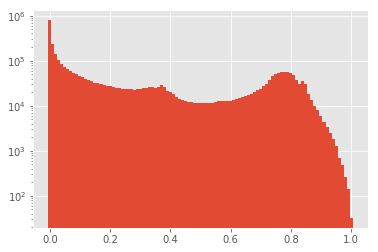

In [13]:
plt.hist(crab_data.gamma_prediction, bins=(np.arange(102) - 0.5) /  100)
plt.yscale('log')
None

Obviously the width of the considered intervall is from 0 to 0.03 $theta^2$ in degree. 

In [34]:
on_data, off_data = split_on_off_source_independent(crab_data.query('gamma_prediction > 0.74'), theta2_cut=0.03)
li_ma_significance(len(on_data), len(off_data), 0.2)

32.535996902728456

In [27]:
selected = crab_data.query('gamma_prediction >= 0.90')
theta_on = selected.theta_deg
theta_off = pd.concat([selected['theta_deg_off_' + str(i)] for i in range(1, 6)])

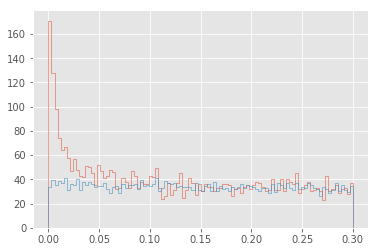

In [16]:
plt.hist(theta_on**2, range=[0, 0.3], bins=100, histtype='step', label='On')
plt.hist(theta_off**2, range=[0, 0.3], bins=100, histtype='step', label='Off', weights=np.full(len(theta_off),  0.2))
None

Li & Ma Theta ^2
xgboost 

In [17]:
from xgboost.sklearn import XGBClassifier
parameters = {
    'max_depth':5,
    'learning_rate':1,
    'gamma':10,
    'booster':'gbtree',
    'silent':0, 
    'nthread':20 ,
    'subsample': 0.3,
    'objective':'binary:logistic',         
    'eval_metric':'auc',
}
rnd = XGBClassifier(**parameters)

In [18]:
rnd.fit(crabTrain.drop('label', axis=1), crabTrain.label)

/home/msackel/.conda/envs/msackel/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-07-07 14:09:10.441928. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=10, learning_rate=1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=20, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=0, subsample=0.3)

In [19]:
pred = rnd.predict_proba(crabTest.drop('label', axis=1))[:,1]
roc_auc_score(crabTest.label, pred)

0.92728488388888886

In [20]:
confXGB = rnd.predict(crabTest.drop('label', axis=1))
confMont= TreeMont.predict(crabTest.drop('label', axis=1))

[Parallel(n_jobs=48)]: Done 100 out of 100 | elapsed:    0.1s finished


In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(crabTest.label, confXGB)

array([[24458,  5542],
       [ 2766, 27234]])

In [22]:
confusion_matrix(crabTest.label, confMont)

array([[23242,  6758],
       [ 3683, 26317]])